- 구글에 Okt 긍부정 머신러닝 해서 나오는 결과물 중
- 6) 네이버 영화 리뷰 감성 분류하기(Naver Movie Review ... 참고했심더

In [1]:
!pip install tensorflow

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import re
import urllib.request
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
okt = Okt()

In [3]:
data1 = pd.read_csv("truffle_zzappa_label.csv")
data2 = pd.read_csv("백종원 있는 미역초무침 댓글 2제외.csv")
data3 = pd.read_csv("mara_1-7445.csv")

In [4]:
data3=data3[data3['label']!=2]

In [5]:
train_data = pd.concat([data1,data2, data3], axis = 0)

In [6]:
del train_data['Unnamed: 0']
del train_data['Unnamed: 0.1']
del train_data['tokens']

In [7]:
print('학습용 리뷰 개수 :',len(train_data))

학습용 리뷰 개수 : 1510


In [8]:
train_data['Comments'].nunique(), train_data['label'].nunique()

(1494, 2)

In [9]:
train_data.drop_duplicates(subset=['Comments'], inplace=True)
print('총 샘플의 수 :',len(train_data))

총 샘플의 수 : 1494


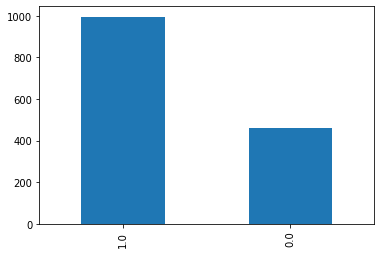

In [10]:
train_data['label'].value_counts().plot(kind = 'bar');

In [11]:
print(train_data.isnull().values.any())

True


In [12]:
print(train_data.isnull().sum())

Comments     0
label       38
dtype: int64


In [13]:
train_data.loc[train_data.label.isnull()].head(5)

,Comments,label
297,내가 잘따르는 마니형 나도 저거 라면 보내주면 안?? ㅋㅋㅋㅋㅋㅋ,NaN
427,이거 개마?遠?개마?遠?1,NaN
671,저는 콜라먹는부분볼려고 시청해?Dㅋㅋㅋㅋㅋ음식먹는것보다 콜라마시장면만보?以빱빱빱빱?...,NaN
744,ㅏ매마뉴마나누?pㅋㅑㄴ매ㅑㄴ어ㅜㅇㅡ?冒칟첸틘疸?매마 뉴마 나누,NaN
780,진짜 미워할 수가 없?い빱빱빱?진짜 미워할 수가 없??2,NaN


In [14]:
train_data = train_data.dropna(how = 'any') # Null 값이 존재하는 행 제거
print(train_data.isnull().values.any()) 

False


In [15]:
train_data['Comments'] = train_data['Comments'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
train_data.head()

,Comments,label
0,솔직히 먹어봤는데 트러플을 접해보지 못한 일반인인 나는 차이를 느끼지 못했다,0.0
1,그냥 짜파게티에 달걀후라이가 젤 맛있음,0.0
2,저는 짜파게티 맛이 예전맛이 안나는거 같아서 항상 아쉬웠었는데 트러플 소스 들어가고...,1.0
3,오 컵라면 뚜껑에 젓가락 끼워놓을 수 있는 곳이 있는줄 몰랐네요ㅋㅋㅋ 완전 꿀팁...,0.0
4,솔직한 리뷰 잘 봤구요 그냥 트러플 오일 하나 사서 두어 방울 뿌려먹는게 낫겠지 ...,0.0


In [16]:
train_data['Comments'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

Comments    0
label       0
dtype: int64


In [191]:
stopwords = ['께서','에서','이다','에게','으로','이랑','까지','부터','하다',
             '구독','편집', '예쁘', '귀엽', '웃기', '해주세요','카와이', '귀엽', '졸귀', '킬포', 
             '개웃겨', '귀욤', '하이라이트', '현웃', '언니', '형', '매력', '언닌', '귀요', 
             '코로나', '재밌', '행님', '목소리','효과음', '선생님', '잘보고있어요', 
             '드셔', '드시', '재밋게',  '사기', '광고', '소리', '잘생겼', 
             '야하', '섹시', '얼굴', '기여', '기엽', '협찬', 'ppl', '배터', 
             '2019', '2020', 'asmr',  'ASMR', '너무예', '편집', '아이돌',  
             '만명', '구독자', '리액션', '슈기', '지원', '복스럽', '이쁘', 
             '존버', '께서','에서','이다','에게','으로','이랑','까지','부터','하다','구독',
             '예쁘', '귀엽', '웃기', '해주세요','카와이', '귀엽', '졸귀', '킬포', '개웃겨', 
             '귀욤', '하이라이트', '현웃', '언니', '형', '매력', '언닌', '귀요', '코로나', 
             '재밌', '행님', '소리','온니','귀여우시다','율송','사랑스럽다','귀여워요',
             '이쁘세요','눈화장','덩이','섀도우','언닝','구독','여리','동수','귀엽네','드머',
             '예뻐','에드','야하네','오빠','빵터지지','썸네일','섹시해','잘생김', '광고', 
             '단무지', '하세용', '표정', '그릇', '모습', '나름', '귀여워', '이뽀', '웃겨욬', 
             '소리', '이쁘세요', '귀여워요', '존경', '브금', '댓글', '배고파졌어용', '자세한', 
             '리뷰', '재미', '빠르다', '배고파요', '예뻐요', '컨셉', '드세요', '보겠어', 
             '다이어트', '면치기', '쌍수', '햇님', '창의력', '도끼', '텐션', '유튜브', 
             '상남자',  '자막', '귀염', '재밋', '개그맨', '질럿님', '일본', '귀여웡', '강동원', 
             '미래', '살', '째현이', '재현', '주라', '강아지', '잘생기셧어', '잘생', '세아님',
             '잘생겼어요', '오랜만에', '파투님', '숙제', '읽었나요', '카메라', '오빠', '이쁘다',
             '안전운전', '안녕하세요', '채널', '은희', '미미', '새벽', '알람', 
             '개그', '꿀잼', '엔딩', '인트로', '무리', '잠시', '틴트','벤쯔','밴쯔','밴쯔님','배다','쯔','님','동생', '화장', 
             '뽀로로', '젓가락', '젖가락', '언니', '풀메', '화장', '싸운건가', '렌즈', '숟가락', '귀욥', '싸가지', '불상해', '살', 
             '이뻐', '예뻐', '반팔티', '거슬리나', '티샤스', '예뻐', '온니', '섹시', '소리', '썸넬', '유튜버', '머리카락', 
             '주둥이', '장염','다시마','초심','정상인','하이','안녕하세요','존예','설명','고물','주승',
             '현우','지윤','귀여우','멍청', '정수기', '동무','난독증','알고', '인건', '서영', '하영', '현우', '서연', '동훈', '성준', '주승',
             '설명', '생일', '닮으', '책상', '김발', '베트맨', '님', '수고비', '나름', '소프', '가르마', '다다푸드', '초전', '개띵작',
             '고물', '도끼', '스펙타클', '불판', '누님', '삐', '도마', '나레이션', '남자', '제이슨',
             '토르', '유트버', '전기톱', '님', '미래', '콘텐츠', '컨텐츠', 
             '냉면', '돈까스', '잘드신다', '이벤트', '백현', '제이제이', '서울특별시', '괜찮', '뿜었', '왼팔',
             '빵터','웃겨요','년전','반전','긴니','먹어주세요', '말레이시아', '보세요', '겜', '편집', '화이띵',
             '진공청소기','화이팅']
             

In [18]:
X_train = []
for sentence in train_data['Comments']:
    temp_X = []
    temp_X = okt.morphs(sentence, stem=True) # 토큰화
    #temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    X_train.append(temp_X)

In [19]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [20]:
threshold = 2
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 3100
등장 빈도가 1번 이하인 희귀 단어의 수: 1626
단어 집합에서 희귀 단어의 비율: 52.45161290322581
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 7.313781935948183


In [21]:
vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

단어 집합의 크기 : 1475


In [22]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') 
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)

In [23]:
y_train = np.array(train_data['label']) 

In [24]:
drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]

In [25]:
X_train = np.delete(X_train, drop_train, axis=0)
y_train = np.delete(y_train, drop_train, axis=0)
print(len(X_train))
print(len(y_train))

1456
1456


리뷰의 최대 길이 : 220
리뷰의 평균 길이 : 15.26923076923077


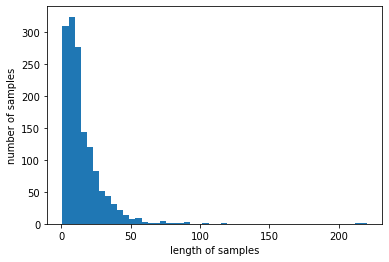

In [26]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [27]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [28]:
max_len = 40
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 40 이하인 샘플의 비율: 94.98626373626374


In [29]:
X_train = pad_sequences(X_train, maxlen = max_len)

In [30]:
from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [31]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

In [32]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [33]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[es, mc], batch_size=60, validation_split=0.2)

Epoch 1/15
19/20 [===========================>..] - ETA: 0s - loss: 0.6569 - acc: 0.7053
Epoch 00001: val_acc improved from -inf to 0.52055, saving model to best_model.h5
20/20 [==============================] - 1s 60ms/step - loss: 0.6524 - acc: 0.7088 - val_loss: 0.9504 - val_acc: 0.5205
Epoch 2/15
19/20 [===========================>..] - ETA: 0s - loss: 0.5350 - acc: 0.7263
Epoch 00002: val_acc did not improve from 0.52055
20/20 [==============================] - 1s 35ms/step - loss: 0.5351 - acc: 0.7251 - val_loss: 0.6963 - val_acc: 0.5205
Epoch 3/15
19/20 [===========================>..] - ETA: 0s - loss: 0.4145 - acc: 0.8044
Epoch 00003: val_acc improved from 0.52055 to 0.64041, saving model to best_model.h5
20/20 [==============================] - 1s 35ms/step - loss: 0.4159 - acc: 0.8050 - val_loss: 0.6183 - val_acc: 0.6404
Epoch 4/15
19/20 [===========================>..] - ETA: 0s - loss: 0.3010 - acc: 0.8895
Epoch 00004: val_acc improved from 0.64041 to 0.68836, saving model

In [34]:
loaded_model = load_model('best_model.h5')

In [35]:
def sentiment_predict(new_sentence):
    new_sentence = okt.morphs(new_sentence, stem=True) # 토큰화
    new_sentence = [word for word in new_sentence if not word in stopwords] # 불용어 제거
    encoded = tokenizer.texts_to_sequences([new_sentence]) # 정수 인코딩
    pad_new = pad_sequences(encoded, maxlen = max_len) # 패딩
    score = float(loaded_model.predict(pad_new)) # 예측
            
    if score > 0.5:
        label = 1
    else: 
        label = 0    
    return(label)

- sinsin = pd.read_csv('신라면건면_Raw.csv',encoding='cp949')
- garlic = pd.read_csv('갈릭버터_Raw.csv',encoding='cp949') 
- 위와 같이 데이터 프레임을 불러옵니다 토큰화하기 이전의 전체 문장csv를 넣어주셔야합니다

In [304]:
dataframe = pd.read_csv('chaehwang_tokenization.csv')
dataframe.shape

(259, 2)

In [305]:
for word in stopwords:
    dataframe= dataframe[~dataframe['Comments'].str.contains(word)]
dataframe.shape

(221, 2)

In [306]:
#dataframe= dataframe[['Comments']]

In [307]:
#Null 값 없애기
dataframe=dataframe.dropna()
dataframe.isnull().sum()

Unnamed: 0    0
Comments      0
dtype: int64

In [308]:
dataframe.reset_index(inplace=True, drop=True)
dataframe.shape

(221, 2)

In [309]:
comment_list = list(dataframe['Comments'])
label_list = []
                    
for item in comment_list:
    label_list.append(sentiment_predict(item))
    
dataframe['label']=label_list

In [310]:
neg= dataframe[dataframe['label']==0]['label'].count()
pos= dataframe[dataframe['label']==1]['label'].count()
print("부정적 댓글 percent:",neg/dataframe['label'].count())
print("긍정적 댓글 percent:",pos/dataframe['label'].count())

부정적 댓글 percent: 0.23529411764705882
긍정적 댓글 percent: 0.7647058823529411


In [311]:
dataframe

,Unnamed: 0,Comments,label
0,0,채식주의자아니여도저처럼우유알러지나계란알러지있는분들많은데알러지있는분들도먹을수있어요보통...,1
1,2,열라면 진라면 채황라면진열하면진짜신호등이겠네요ㅋㅋㅋㅋ,1
2,3,비건라면이네 진짜채식주의자들한테는좋을듯,1
3,8,굉장히깔끔하고안짜고채소가어마하게들어가있습디다 저는계속먹을듯해요 비건은아니지만채수의감...,0
4,10,자괴감덜드는라면,1
...,...,...,...
216,1877,맛있어보여요,1
217,1887,힘들게찾으셧습니다,1
218,1891,아구그렇게매운거오래사시겠어요,1
219,1895,가끔이분영상보면서느끼는건데이분은매운감각이없으신가,0


In [312]:
dataframe.to_csv('채황_label.csv')